In [1]:
import numpy as np
from TDD.TDD import Index,Ini_TDD,Clear_TDD,set_index_order,get_tdd,get_count
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs
from TDD.TDD_Q import reshape as reshape2
from TDD.TN import Tensor,TensorNetwork

from qiskit import QuantumCircuit
from sympy import *
from sympy.parsing.sympy_parser import parse_expr
from TDD.TDD import get_unique_table_num as gu1
from TDD.SymTDD.BDD import get_unique_table_num as gu2
from TDD.SymTDD.BDD import get_count as B_get_count

import time ,random, csv


可能之後寫個 BDD.get_supp() 放在Sym_TDD裡。



In [2]:
def simulation(input_cir, Benchmark_Name=None,symbolic=True, unique_table_reset=True,output_file=None):
    if isinstance(input_cir,QuantumCircuit):
        cir=input_cir
    else:
        cir=QuantumCircuit.from_qasm_file(input_cir)
        if not Benchmark_Name:
            Benchmark_Name=input_cir
    tn,indices=cir_2_tn(cir)
    if symbolic:
        for k in range(tn.qubits_num):
            x_k='x'+str(k)
            xn_k='xn'+str(k)
            s=Symbol(x_k)
            ns=Symbol(xn_k)
            U=np.array([ns,s])
            # U=np.array([0,1])
            temp_ts=Tensor(U,[Index(x_k)])
            tn.tensors.insert(0,temp_ts)
            if not x_k in indices:
                indices.append(x_k)
    t_start=time.time()
    Ini_TDD(indices,n=300,type='SymTDD',unique_table_reset=unique_table_reset)
    # Ini_TDD(indices,n=300,unique_table_reset=unique_table_reset)
    tdd,Max_node_num=tn.cont(max_node=True)
    Time=time.time()-t_start
    print('Benchmark Name:',Benchmark_Name)
    print('Time:',time.time()-t_start)
    print('Qubit num.:',tn.qubits_num)
    print('Gate num.:',len(cir.data))
    print('Node num. max:',Max_node_num)
    print('Node num. final:',tdd.node_number())
    print('gu1:',gu1())
    print('gu2:',gu2())
    if output_file:
        with open(output_file, 'a', newline='') as csvfile:
            fieldnames = ['Benchmark Name', 'Qubit num.','Gate num.','Time','Node num. max','Node num. final','gu1','gu2']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'Benchmark Name':Benchmark_Name,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':Time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()})
    return tdd

Benchmark Name: Benchmarks/qft_5.qasm
Time: 0.01603412628173828
Qubit num.: 5
Gate num.: 15
Node num. max: 6
Node num. final: 6
gu1: 88
gu2: 46


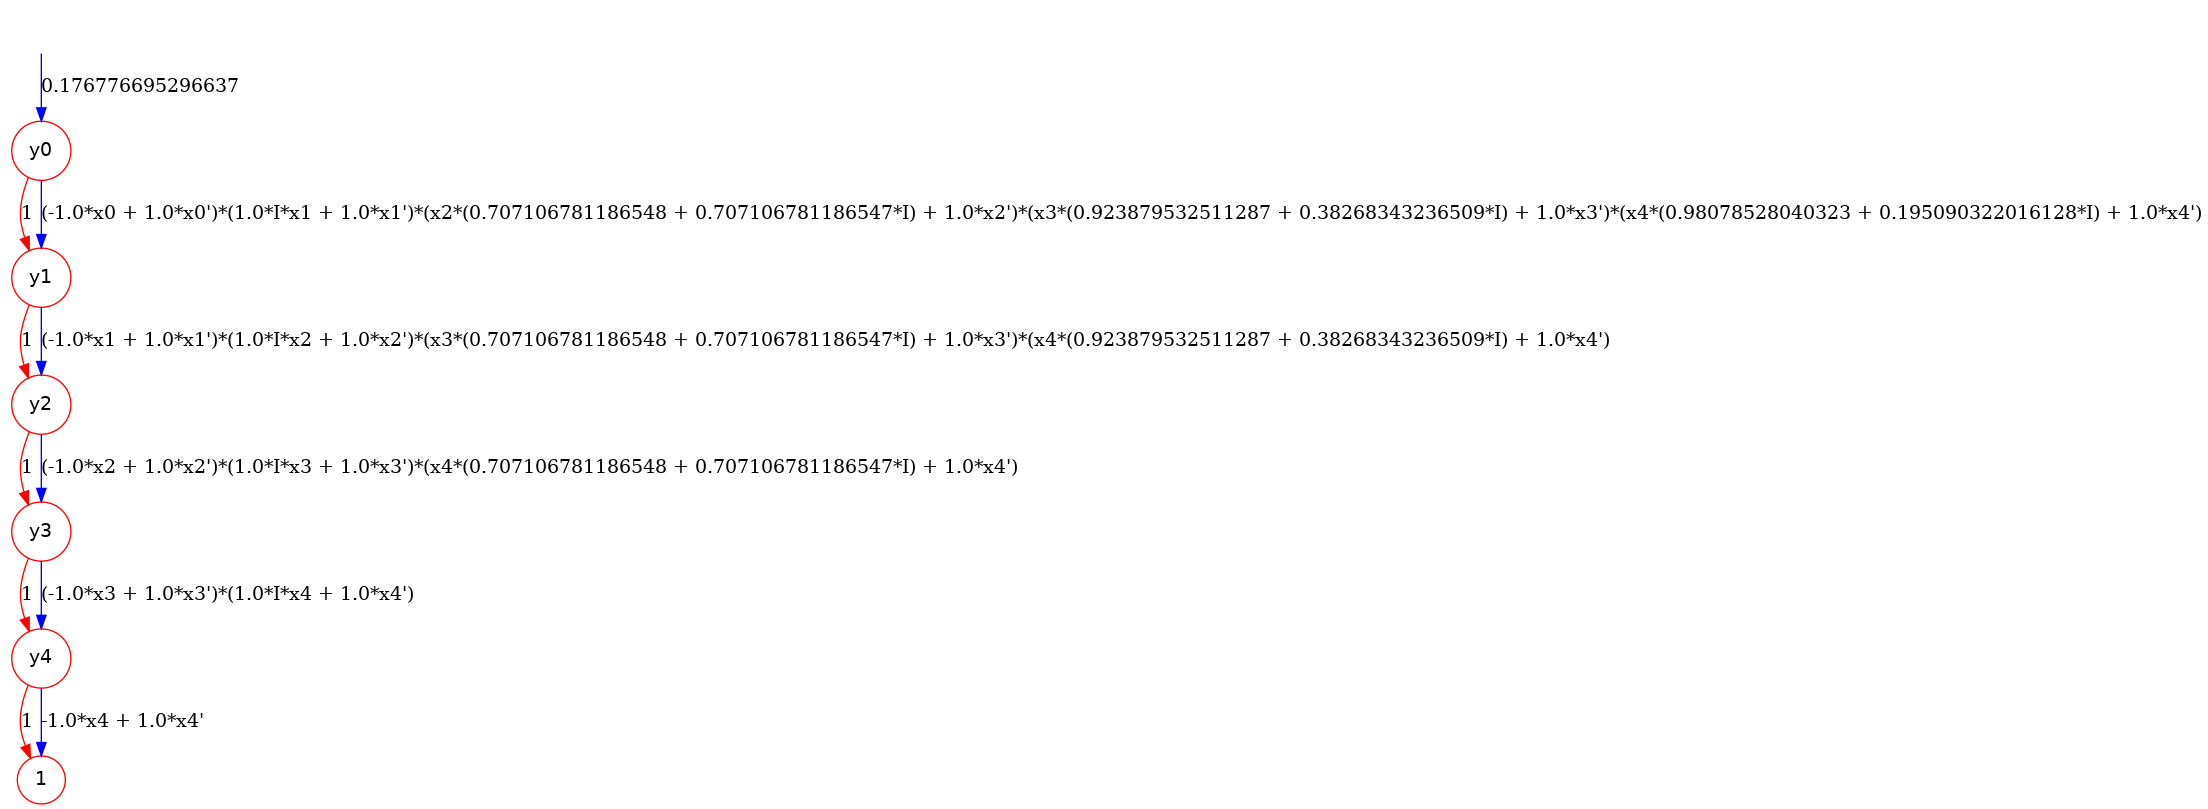

In [3]:
import os
path='Benchmarks/'
files=os.listdir(path)

tdd=simulation(path+files[0],symbolic=True)
tdd.show()

(-1.0*x0 + 1.0*x0')*(1.0*I*x1 + 1.0*x1')*(x2*(0.707106781186548 + 0.707106781186547*I) + 1.0*x2')*(x3*(0.923879532511287 + 0.38268343236509*I) + 1.0*x3')*(x4*(0.98078528040323 + 0.195090322016128*I) + 1.0*x4')


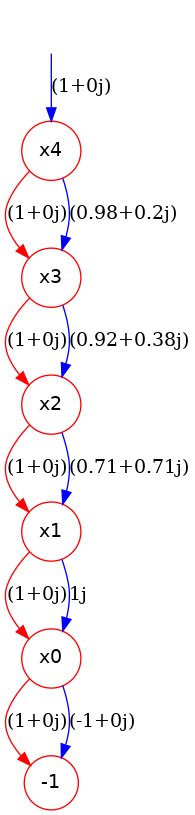

In [4]:
print(tdd.node.out_weight[1])
tdd.node.out_weight[1].show()

In [5]:
def BDD_Inorder(node,state=set(),weight=1,buffer={}):
    if node.key==-1:
        if weight!=0:
            # print(state,weight)
            buffer[frozenset(state.copy())]=weight 
        return
    outweight=node.out_weight

    state.add(node.key+"'")
    # First recur on left child
    BDD_Inorder(node.successor[0],state,weight=weight*outweight[0],buffer=buffer)

    # then print the data of node
    # now recur on right child

    state.discard(node.key+"'")
    state.add(node.key)
    BDD_Inorder(node.successor[1],state,weight=weight*outweight[1],buffer=buffer)
    state.discard(node.key)

Use BDD_Inorder can obtain the TDD weight all supp() and the correspond value.

In [6]:
buffer={}
BDD=tdd.node.out_weight[1]
BDD_Inorder(BDD.node,weight=BDD.weight,buffer=buffer)
buffer

{frozenset({"x0'", "x1'", "x2'", "x3'", "x4'"}): (1+0j),
 frozenset({'x0', "x1'", "x2'", "x3'", "x4'"}): (-1+0j),
 frozenset({"x0'", 'x1', "x2'", "x3'", "x4'"}): 1j,
 frozenset({'x0', 'x1', "x2'", "x3'", "x4'"}): (-0-1j),
 frozenset({"x0'",
            "x1'",
            'x2',
            "x3'",
            "x4'"}): (0.7071067811865476+0.7071067811865475j),
 frozenset({'x0',
            "x1'",
            'x2',
            "x3'",
            "x4'"}): (-0.7071067811865476-0.7071067811865475j),
 frozenset({"x0'",
            'x1',
            'x2',
            "x3'",
            "x4'"}): (-0.7071067811865475+0.7071067811865476j),
 frozenset({'x0',
            'x1',
            'x2',
            "x3'",
            "x4'"}): (0.7071067811865475-0.7071067811865476j),
 frozenset({"x0'",
            "x1'",
            "x2'",
            'x3',
            "x4'"}): (0.9238795325112867+0.3826834323650898j),
 frozenset({'x0',
            "x1'",
            "x2'",
            'x3',
            "x4'

In [7]:
supp=buffer.keys()
supp

dict_keys([frozenset({"x0'", "x4'", "x2'", "x3'", "x1'"}), frozenset({"x2'", "x4'", 'x0', "x3'", "x1'"}), frozenset({"x2'", "x4'", "x0'", 'x1', "x3'"}), frozenset({"x2'", "x4'", 'x0', 'x1', "x3'"}), frozenset({"x0'", "x4'", 'x2', "x3'", "x1'"}), frozenset({"x4'", 'x0', 'x2', "x3'", "x1'"}), frozenset({"x0'", "x4'", 'x1', 'x2', "x3'"}), frozenset({"x4'", 'x0', 'x1', 'x2', "x3'"}), frozenset({"x2'", "x4'", "x0'", 'x3', "x1'"}), frozenset({"x2'", "x4'", 'x0', 'x3', "x1'"}), frozenset({"x2'", "x4'", "x0'", 'x1', 'x3'}), frozenset({"x2'", "x4'", 'x0', 'x1', 'x3'}), frozenset({"x0'", "x4'", 'x2', 'x3', "x1'"}), frozenset({"x4'", 'x0', 'x2', 'x3', "x1'"}), frozenset({"x0'", "x4'", 'x1', 'x2', 'x3'}), frozenset({"x4'", 'x0', 'x1', 'x2', 'x3'}), frozenset({"x2'", "x0'", "x3'", 'x4', "x1'"}), frozenset({"x2'", 'x0', "x3'", 'x4', "x1'"}), frozenset({"x2'", "x0'", 'x1', "x3'", 'x4'}), frozenset({"x2'", 'x0', 'x1', "x3'", 'x4'}), frozenset({"x0'", 'x2', "x3'", 'x4', "x1'"}), frozenset({'x0', 'x2', 

In [8]:
frozenset({"x4'", "x2'", "x0'", "x1'", "x3'"}) in supp

True

In [9]:
buffer[frozenset({"x4","x0'",  "x2", "x1", "x3"})]

(-0.9807852804032302+0.1950903220161283j)

In [10]:
for item in supp:
    print(item)

frozenset({"x0'", "x4'", "x2'", "x3'", "x1'"})
frozenset({"x2'", "x4'", 'x0', "x3'", "x1'"})
frozenset({"x2'", "x4'", "x0'", 'x1', "x3'"})
frozenset({"x2'", "x4'", 'x0', 'x1', "x3'"})
frozenset({"x0'", "x4'", 'x2', "x3'", "x1'"})
frozenset({"x4'", 'x0', 'x2', "x3'", "x1'"})
frozenset({"x0'", "x4'", 'x1', 'x2', "x3'"})
frozenset({"x4'", 'x0', 'x1', 'x2', "x3'"})
frozenset({"x2'", "x4'", "x0'", 'x3', "x1'"})
frozenset({"x2'", "x4'", 'x0', 'x3', "x1'"})
frozenset({"x2'", "x4'", "x0'", 'x1', 'x3'})
frozenset({"x2'", "x4'", 'x0', 'x1', 'x3'})
frozenset({"x0'", "x4'", 'x2', 'x3', "x1'"})
frozenset({"x4'", 'x0', 'x2', 'x3', "x1'"})
frozenset({"x0'", "x4'", 'x1', 'x2', 'x3'})
frozenset({"x4'", 'x0', 'x1', 'x2', 'x3'})
frozenset({"x2'", "x0'", "x3'", 'x4', "x1'"})
frozenset({"x2'", 'x0', "x3'", 'x4', "x1'"})
frozenset({"x2'", "x0'", 'x1', "x3'", 'x4'})
frozenset({"x2'", 'x0', 'x1', "x3'", 'x4'})
frozenset({"x0'", 'x2', "x3'", 'x4', "x1'"})
frozenset({'x0', 'x2', "x3'", 'x4', "x1'"})
frozenset({

You can use the set() function to create a set, and then use the set as a key in a dictionary by converting it to a frozenset first. Here's an example:





In [11]:
my_set = set([1, 2, 3])

my_dict = {}

# convert the set to a frozenset and use it as a key
my_dict[frozenset(my_set)] = "hello"

# print the dictionary
print(my_dict)

{frozenset({1, 2, 3}): 'hello'}


In this example, we create a set called my_set that contains the elements 1, 2, and 3, and then we create an empty dictionary called my_dict. We use the frozenset() function to convert my_set to a frozenset and then use it as a key in my_dict, storing the value "hello" at that key. Finally, we print the dictionary to see that the key-value pair has been added.

You can also use a set as a key in a dictionary directly, without converting it to a frozenset first. However, this is not recommended, because sets are not hashable, meaning they cannot be used as keys in a dictionary. If you try to use a set as a key in a dictionary, you may get an error.

In summary, to use a set as a key in a dictionary, you should convert it to a frozenset first, and then use the frozenset as the key in the dictionary. This will ensure that the key is hashable and can be used in the dictionary without any issues.